# Create figure with coverage of stations

Note: this requires raw precipitation time series for all observed data products, which can be downloaded from each products' respective data storage.

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import os
import re
import glob
from matplotlib import pyplot as plt
import matplotlib as mpl
from cartopy import crs as ccrs
import cmocean
import warnings

from funcs_load import load_raws
from funcs_support import get_filepaths,get_params,subset_to_srat,utility_print,area_mean
dir_list = get_params()

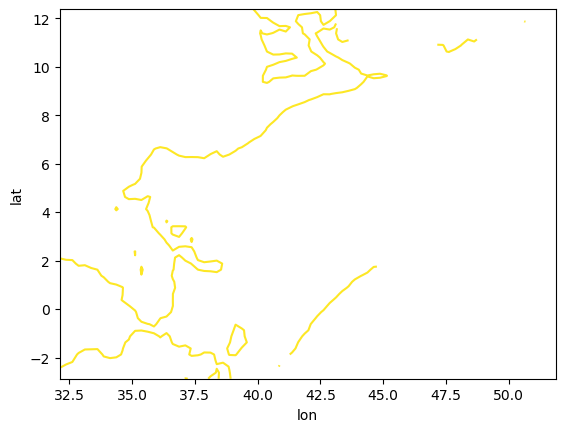

In [2]:
srat = xr.open_dataset(dir_list['aux']+'pr_doyavg_CHIRPS_historical_seasstats_dunning_19810101-20141231_HoAfrica.nc').seas_ratio
# Create simplified Polygon of double-peaked region
srat_reg = srat.plot.contour(levels=[1])
srat_reg = shapely.geometry.Polygon(np.vstack([srat_reg.allsegs[0][2],srat_reg.allsegs[0][5],
           np.array([[55,12.5],[55,-3]])]))

In [3]:
# Load station time series 
dssr = {'GHCN':(xr.open_dataset(dir_list['raw']+'GHCN/pr_Amon_GHCN_historical_stations_18780401-20240531_HoAfrica-stns.nc').
                 rename({'id':'station'})),
        'NIC131':xr.open_dataset(dir_list['raw']+'NIC131/pr_Amon_NIC131_historical_stations_18190101-20191031_Africa.nc')}
# Get which stations are in the region 
for mod in dssr:
    dssr[mod]['in_studyreg'] = (('station'),
              [srat_reg.contains(shapely.Point(dssr[mod].isel(station=stn_idx).lon.values,
                                               dssr[mod].isel(station=stn_idx).lat.values))
                for stn_idx in range(dssr[mod].sizes['station'])])

# Subset by stations in region
dssr = {mod:ds[['pr']].where(ds['in_studyreg'],drop=True)
        for mod,ds in dssr.items()}

In [4]:
subset_params = {'lat':slice(-3,12.5),'lon':slice(32,55)}

fns = {'CRU-TS':['/dx02/kschwarz/climate_raw/CRU-TS/pr_Amon_CRU-TS_historical_obs_19010101-20221231.nc','stn'],
       'GPCC-monitoring':['/dx02/kschwarz/climate_raw/GPCC-monitoring/pr_Amon_GPCC-monitoring_historical_obs_19820101-20231031.nc',
                          'nstations'],
       'GPCC-full':['/dx02/kschwarz/climate_raw/GPCC-full/stnmeta_Amon_GPCC-full_historical_obs_18910101-20201231.nc',
                    'numgauge'],
       'TerraClimate':['/dx02/kschwarz/climate_raw/TerraClimate/pr_Amon_TerraClimate_historical_obs_19580101-20151231_HoAfrica.nc',
                       'station_influence']}

# Get double-peaked area means of products that show station density per grid cell 
dss = {mod:area_mean(subset_to_srat(xr.open_dataset(fn[0]).sel(**subset_params)[fn[1]]))
       for mod,fn in fns.items()}

In [5]:
# Homogenize calendars
for mod in dss:
    dss[mod]['time'] = pd.date_range(str(dss[mod].time.min().values)[0:8]+'01',
              str(dss[mod].time.max().values)[0:8]+'30',freq='1MS')+pd.DateOffset(days=15)

# Concatenate
dss = xr.concat([ds for mod,ds in dss.items()],
          dim=pd.Index([mod for mod in dss],name='model'))

/home/kschwarz/projects/future_stability/figures/figureS2.pdf saved!
/home/kschwarz/projects/future_stability/figures/figureS2.png saved!


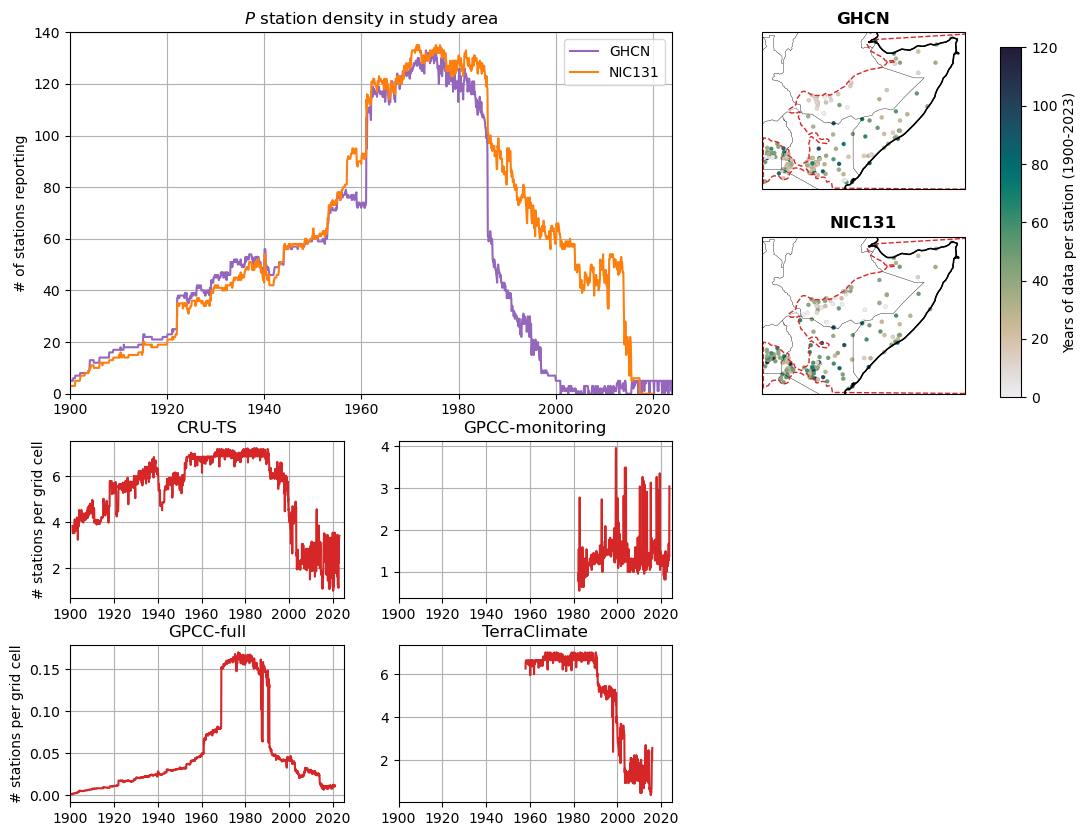

In [6]:
fig = plt.figure(figsize=(12,10))
# Now create the tiled board
spec = fig.add_gridspec(4,3,hspace=0.3)


save_fig = True
#output_fn = dir_list['figs']+'figure_stationcoverage'
output_fn = dir_list['figs']+'figureS2'

#-------- Plot for number of stations reporting --------
colors = {'GHCN':'tab:purple',
          'NIC131':'tab:orange'}

ax = fig.add_subplot(spec[slice(0,2),slice(0,2)])

for mod in dssr:
    (~np.isnan(dssr[mod])).pr.sum('station').plot(color=colors[mod],label=mod)

ax.set_xlim(pd.to_datetime(['1900-01-01','2023-12-31']))
ax.set_ylim(0,140)
ax.grid()

ax.legend()

ax.set_ylabel(r'# of stations reporting')
ax.set_title(r'$P$ station density in study area')
ax.set_xlabel('')


#-------- Maps of station locations --------
cbar_params = {'cmap':cmocean.cm.rain,'vmin':0,'vmax':120}
for mod,mod_idx in zip(dssr,range(len(dssr))):
    ax = fig.add_subplot(spec[mod_idx,2],projection=ccrs.PlateCarree())

    # Get how many years of data in obs
    prop_obs = (~np.isnan(dssr[mod]['pr'].sel(time=slice('1900-01-01','2023-12-31')))).sum('time')/12

    # Plot
    s = ax.scatter(dssr[mod].lon.values,
                dssr[mod].lat.values,
                edgecolor='grey',
                linewidths=0.1,
                marker='.',c=prop_obs,
                  **cbar_params,
                transform=ccrs.PlateCarree(),
                )
    ax.coastlines()

    # Get ISO-standard borders
    gdf = gpd.read_file('/dx01/kschwarz/aux_data/ne_10m_admin_0_countries_iso/ne_10m_admin_0_countries_iso.shp')
    # Add to plot
    gdf.cx[slice(32,52),slice(-3,12.5)].plot(ax=ax,facecolor='none',edgecolor='k',
                                                           linestyle='-',linewidth=0.15,
                                                           transform=ccrs.PlateCarree())

    # Get geodataframe of the polygon of the (simplified) double-peaked region
    gdf_reg = gpd.GeoDataFrame(geometry=[srat_reg])
    # Add double-peaked region boundary
    gdf_reg.plot(facecolor='none',edgecolor='tab:red',linestyle='--',ax=ax)

    ax.set_extent([32,52,-3,12.5])

    ax.set_title(mod,fontweight='bold',fontsize=12)
    
    ax.coastlines()

# Vertical colorbar
#fig.subplots_adjust(right=0.825)
cax = fig.add_axes([0.90, 0.515, 0.0175, 0.35])
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(cbar_params['vmin'], cbar_params['vmax']), cmap=cbar_params['cmap']),
             cax=cax, orientation='vertical', label='Years of data per station (1900-2023)')


#-------- Gridded data product station numbers --------
for mod,mod_idx in zip(dss.model.values,range(dss.sizes['model'])):
    col = mod_idx % 2
    row = (mod_idx // 2) + 2
    ax = fig.add_subplot(spec[row,col])

    dss.sel(model=mod).plot(color='tab:red')

    ax.set_title(mod)
    ax.set_xlabel('')
    if col == 0:
        ax.set_ylabel('# stations per grid cell')
    
    ax.set_xlim([pd.to_datetime('1900-01-01'),
                 pd.to_datetime('2024-12-31')])

    ax.grid()

if save_fig:
    utility_print(output_fn)